# Initial setup

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-92cc8bb1-e289-cd13-101c-631593274010)


In [2]:
# to print all output for a cell instead of only last one 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
#import all libraries and modules 

import os

import requests
import zipfile
import random
import string 

import torch

import numpy as np
import pandas as pd

import gensim
import gensim.downloader as gloader
from gensim.models import KeyedVectors

import time 
import logging
import tqdm

from collections import OrderedDict, namedtuple

import json
from pandas import json_normalize
	
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
print("Current work directory: {}".format(os.getcwd())) #print the current working directory 

data_folder = os.path.join(os.getcwd(),"data") # directory containing the notebook

if not os.path.exists(data_folder):   #create folder where all data will be stored 
    os.makedirs(data_folder)

Current work directory: /content


In [5]:
# Fix data seed to achieve reproducible results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#setup logging 
log = logging.getLogger('logger')
log.setLevel(logging.DEBUG)
fh = logging.FileHandler('data/log.txt')
fh.setLevel(logging.DEBUG)
log.addHandler(fh)

In [6]:
json_file_path_train = "data/train.json"
json_file_path_val = "data/dev.json"
json_file_path_test = "data/test.json"

with open(json_file_path_train, 'r') as tr:
     contents = json.loads(tr.read())
     train = json_normalize(contents)

with open(json_file_path_val, 'r') as vl:
     contents = json.loads(vl.read())
     val = json_normalize(contents) 

with open(json_file_path_test, 'r') as ts:
     contents = json.loads(ts.read())
     test = json_normalize(contents) 

# Dataset inspection

In [7]:
train = train[:4000]
val = val[:2000]
test = test[:500]

train.head(3)

,ID,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,profile.location,...,profile.profile_link_color,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower
0,17461978,[RT @CarnivalCruise: 🎉 Are you ready to see wh...,NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,"Orlando, FL",...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
1,1297437077403885568,None,NaN,[Politics],1,1297437077403885568,1297437077403885568,Jennifer Fishpaw,JenniferFishpaw,,...,1DA1F2,C0DEED,DDEEF6,333333,True,True,True,False,"[170861207, 23970102, 47293791, 29458079, 1799...",[]
2,17685258,[RT @realDonaldTrump: THANK YOU #RNC2020! http...,NaN,"[Politics, Entertainment, Sports]",0,17685258,17685258,Brad Parscale,parscale,Florida,...,AB2316,FFFFFF,FFFFFF,666666,False,False,False,False,"[46464108, 21536398, 18643437, 589490020, 1363...","[1275068515666386945, 2535843469, 129365759103..."


In [8]:
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

Training set size: 4000
Validation set size: 2000
Test set size: 500


In [9]:
print(f"N° of features per account: {len(train.columns)}")
print(f"Features:\n{list(train.columns)}") #TODO: rimuovere tutto ciò che è prima del punto e rinominare le colonne?

N° of features per account: 45
Features:
['ID', 'tweet', 'neighbor', 'domain', 'label', 'profile.id', 'profile.id_str', 'profile.name', 'profile.screen_name', 'profile.location', 'profile.profile_location', 'profile.description', 'profile.url', 'profile.entities', 'profile.protected', 'profile.followers_count', 'profile.friends_count', 'profile.listed_count', 'profile.created_at', 'profile.favourites_count', 'profile.utc_offset', 'profile.time_zone', 'profile.geo_enabled', 'profile.verified', 'profile.statuses_count', 'profile.lang', 'profile.contributors_enabled', 'profile.is_translator', 'profile.is_translation_enabled', 'profile.profile_background_color', 'profile.profile_background_image_url', 'profile.profile_background_image_url_https', 'profile.profile_background_tile', 'profile.profile_image_url', 'profile.profile_image_url_https', 'profile.profile_link_color', 'profile.profile_sidebar_border_color', 'profile.profile_sidebar_fill_color', 'profile.profile_text_color', 'profile.p

In [10]:
print(f"N° of accounts without tweets: {train['tweet'].isna().sum()}")
print(f"N° of tweets per account analytics:\n{np.round(train['tweet'].dropna().apply(len)).describe()}")


N° of accounts without tweets: 34
N° of tweets per account analytics:
count    3966.000000
mean      170.911750
std        62.201307
min         1.000000
25%       196.000000
50%       200.000000
75%       200.000000
max       200.000000
Name: tweet, dtype: float64


# Tweets preprocessing

In [11]:
!pip install Unidecode
!pip install emoji
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import unidecode
import nltk
import emoji
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

nltk.download('wordnet', quiet=True) 
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

def lemmatize_and_remove_non_ascii(sentence:str):
    """Remove unnecessary spaces, remove words with non ASCII characters and lemmatize"""
    lemmatizer = WordNetLemmatizer()
    sentence = [lemmatizer.lemmatize(word) for word in sentence if word.isascii()] #if a word has all ASCII characters: lemmatize, else: remove
    return sentence

def stemm_and_remove_non_ascii(sentence: str):
    ps = PorterStemmer()
    sentence = [ps.stem(word) for word in sentence if word.isascii()]#if a word has all ASCII characters: stemm, else: remove
    return sentence

def preprocess_pipeline(sentence:str):
    """Apply standard preprocessing"""

    #put everything to lowercase
    sentence = sentence.lower()

    #remove all unnecessary spaces and return a list of words
    sentence = sentence.split()

    return sentence

def preprocess_type1(sentence:str):
    """Apply standard preprocessing and return a list of words"""

    sentence = preprocess_pipeline(sentence)

    #TODO: decidere con cosa sostituire i caratteri speciali (@, link, RT, emoticons...)
    #replace link string with 'https'
    sentence = ['https' if 'http' in word else word for word in sentence]

    #remove emoticons
    sentence = [word for word in sentence if not emoji.is_emoji(word)]

    #remove all punctuation
    sentence = [word.translate(str.maketrans(dict.fromkeys(string.punctuation,''))) for word in sentence]

    return sentence

def preprocess_type2(sentence:str):
    """Apply standard preprocessing and return a list of words"""

    sentence = preprocess_pipeline(sentence)

    #TODO: decidere con cosa sostituire i caratteri speciali (@, link, RT, emoticons...)
    #replace link string with 'https'
    sentence = ['https' if 'http' in word else word for word in sentence]

    #replace emoticons with their descriptions
    sentence = [emoji.demojize(word) if emoji.is_emoji(word) else word for word in sentence]
    
    #transliterates any UNICODE string into the closest possible representation in ASCII text
    sentence = [unidecode.unidecode(word) for word in sentence]

    #remove all punctuation
    sentence = [word.translate(str.maketrans(dict.fromkeys(string.punctuation,''))) for word in sentence]

    sentence = [word for word in sentence if word != '']

    return sentence

def preprocess_type3(sentence:str):
    """Lower, split, links to 'https', translate emoji, translate to UNICODE, no punctuation"""

    sentence = preprocess_pipeline(sentence)

    #replace url link string with 'uuuuu'
    sentence = ['uuuuu' if 'http' in word else word for word in sentence]

    #replace account link string with 'ttttt'
    sentence = ['ttttt' if '@' in word else word for word in sentence]

    #replace hashtag with 'ggggg'
    sentence = ['ggggg' if '#' in word else word for word in sentence]

    #replace emoticons with 'eeeee'
    sentence = ['eeeee' if emoji.is_emoji(word) else word for word in sentence]
    
    #transliterates any UNICODE string into the closest possible representation in ASCII text
    # sentence = [unidecode.unidecode(word) for word in sentence]

    #remove all punctuation
    sentence = [word.translate(str.maketrans(dict.fromkeys(string.punctuation,''))) for word in sentence]

    #if a word has one non-ASCII character: remove
    sentence = [word for word in sentence if word.isascii()]

    sentence = [word for word in sentence if word != '']

    return sentence

def preprocess_type4(sentence:str):
    """Apply standard preprocessing, transliterates UNICODE characters in ASCII, 
    remove words with non ASCII characters, lemmatize and return a list of words"""

    sentence = preprocess_pipeline(sentence)

    #remove non-ascii words
    sentence = lemmatize_and_remove_non_ascii(sentence) #TODO: lemmatization doesn't work

    return sentence

def preprocess_type5(sentence: str):
    """
        Apply standard preprocessing, removes stop-words and non ascii's,  and stemmes.
    """
    sentence = preprocess_pipeline(sentence)
    stemmed = stemm_and_remove_non_ascii(sentence)
    stop_words = set(stopwords.words('english'))
    filter_stop_words = [word for word in stemmed if not word in stop_words]
    return filter_stop_words

True

True

True

In [13]:
print(f"Original tweet:\n{train.loc[0, 'tweet'][0]}")
print(f"Processed tweet with type 2:\n{preprocess_type2(train.loc[0, 'tweet'][0])}")
print(f"Processed tweet with type 3:\n{preprocess_type3(train.loc[0, 'tweet'][0])}")

Original tweet:
RT @CarnivalCruise: 🎉 Are you ready to see what our newest ship’s name will be? 🎉 Thanks to all our partners for helping us unbox the name.…

Processed tweet with type 2:
['rt', 'carnivalcruise', 'partypopper', 'are', 'you', 'ready', 'to', 'see', 'what', 'our', 'newest', 'ships', 'name', 'will', 'be', 'partypopper', 'thanks', 'to', 'all', 'our', 'partners', 'for', 'helping', 'us', 'unbox', 'the', 'name']
Processed tweet with type 3:
['rt', 'ttttt', 'eeeee', 'are', 'you', 'ready', 'to', 'see', 'what', 'our', 'newest', 'name', 'will', 'be', 'eeeee', 'thanks', 'to', 'all', 'our', 'partners', 'for', 'helping', 'us', 'unbox', 'the']


In [14]:
# Remove all accounts without tweets
train.dropna(subset=['tweet'], inplace=True)
val.dropna(subset=['tweet'], inplace=True)
test.dropna(subset=['tweet'], inplace=True)

train = train.explode('tweet').reset_index(drop=True)
val = val.explode('tweet').reset_index(drop=True)
test = test.explode('tweet').reset_index(drop=True)

# Preprocess all tweets
train['tweet'] = train['tweet'].apply(preprocess_type3)
val['tweet'] = val['tweet'].apply(preprocess_type3)
test['tweet'] = test['tweet'].apply(preprocess_type3)

train = train[train['tweet'].map(lambda x: len(x)) > 0].reset_index()
train.rename(columns={"index": "tweet_id", "ID": "account_id"}, inplace=True)
val = val[val['tweet'].map(lambda x: len(x)) > 0].reset_index()
val.rename(columns={"index": "tweet_id", "ID": "account_id"}, inplace=True)
test = test[test['tweet'].map(lambda x: len(x)) > 0].reset_index()
test.rename(columns={"index": "tweet_id", "ID": "account_id"}, inplace=True)

print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

train.head(3)

Training set size: 675776
Validation set size: 335351
Test set size: 83223


,tweet_id,account_id,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,...,profile.profile_link_color,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower
0,0,17461978,"[rt, ttttt, eeeee, are, you, ready, to, see, w...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
1,1,17461978,"[who, has, time, for, receipts, not, me, ttttt...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN
2,2,17461978,"[steady, wants, to, encourage, you, to, invest...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,2FC2EF,181A1E,252429,666666,True,False,False,False,NaN,NaN


# Vocabulary

In [15]:
Vocab = namedtuple('Vocabulary',['word2int','int2word','unique_words'])

def build_vocab(unique_words): 
    """
        Builds the dictionaries word2int, int2word and put them in the Vocabulary
    """
    word2int = OrderedDict()
    int2word = OrderedDict()

    for i, word in enumerate(unique_words):
        word2int[word] = i+1           #plus 1 since the 0 will be used as tag token 
        int2word[i+1] = word
    
    return Vocab(word2int,int2word,unique_words)

In [16]:
unique_words_train = train['tweet'].explode().unique().tolist()
unique_words_val = val['tweet'].explode().unique().tolist()
unique_words_test = test['tweet'].explode().unique().tolist()

print('The number of unique words belonging to training set is:', len(unique_words_train))
print('The number of unique words belonging to validation set is:', len(unique_words_val))
print('The number of unique words belonging to test set is:', len(unique_words_test))

unique_words = set(unique_words_train + unique_words_val + unique_words_test)
print('The number of unique words in the entire dataset is:', len(unique_words))

The number of unique words belonging to training set is: 244679
The number of unique words belonging to validation set is: 169751
The number of unique words belonging to test set is: 70490
The number of unique words in the entire dataset is: 339919


In [17]:
vocab = build_vocab(unique_words)

In [18]:
def build_indexed_dataframe(df: pd.DataFrame):

    df['idx_tweet'] = df.tweet.apply(lambda x:list(map(vocab.word2int.get,x)))
    df['label'] = df.label.astype('category')   #convert the label column into category dtype
    df['label'] = df.label.cat.codes        #assign unique integer to each category
    df['tweet_id'] = df['tweet_id'].astype(np.int64)

    return df 

def check_dataframe_numberization(df,vocab):

    """
       Checks if the numberized dataframe will lead to the normal dataframe usind the reverse mapping 
    """

    tweet = df['tweet']

    idx_to_tweet = df.idx_tweet.apply(lambda x:list(map(vocab.int2word.get,x)))

    if tweet.equals(idx_to_tweet):
        print('CHECK COMPLETED: All right with dataset numberization')
    else:
        raise Exception('There are problems with Dataset numberization')

train = build_indexed_dataframe(train)
val = build_indexed_dataframe(val)
test = build_indexed_dataframe(test)

check_dataframe_numberization(train,vocab)

CHECK COMPLETED: All right with dataset numberization


In [19]:
train.head(3)

,tweet_id,account_id,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,...,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower,idx_tweet
0,0,17461978,"[rt, ttttt, eeeee, are, you, ready, to, see, w...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,181A1E,252429,666666,True,False,False,False,NaN,NaN,"[202019, 112973, 19412, 104951, 35730, 331516,..."
1,1,17461978,"[who, has, time, for, receipts, not, me, ttttt...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,181A1E,252429,666666,True,False,False,False,NaN,NaN,"[193444, 39440, 108400, 200373, 130441, 29741,..."
2,2,17461978,"[steady, wants, to, encourage, you, to, invest...",NaN,"[Politics, Business, Entertainment]",0,17461978,17461978,SHAQ,SHAQ,...,181A1E,252429,666666,True,False,False,False,NaN,NaN,"[98989, 279543, 80810, 303019, 35730, 80810, 8..."


# Dataloaders

In [20]:
from torchtext.data import BucketIterator
from torch.utils.data import Dataset

class DataframeDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame):

        dataframe = dataframe.copy()
        self.tweet = dataframe['idx_tweet']      #column of numberized tweets
        self.label = dataframe['label']       #column of categorical label 
        self.id = dataframe['tweet_id']          #column of claim ids 

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, idx):
        return {'tweet': self.tweet[idx],
                'label': self.label[idx],
                'tweet_id': self.id[idx]}

def create_dataloaders(b_s : int, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame):     #b_s = batch_size

    #create DataframeDataset objects for each split 
    train_dataset = DataframeDataset(train)
    val_dataset = DataframeDataset(val)
    test_dataset = DataframeDataset(test)


    # Group similar length text sequences together in batches and return an iterator for each split.
    train_dataloader,val_dataloader,test_dataloader = BucketIterator.splits((train_dataset,val_dataset,test_dataset),
                                                        batch_sizes=(b_s,b_s,b_s), sort_key=lambda x: (len(x['tweet'])), 
                                                        repeat=True, sort=False, shuffle=True, sort_within_batch=True)
    
    return train_dataloader,val_dataloader,test_dataloader 

In [21]:
temp_batch_size = 128
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(temp_batch_size, train, val, test)
random_idx = random.randint(0, temp_batch_size-1)
train_dataloader.init_epoch()
for batch_id, batch in enumerate(train_dataloader.batches):
    print("Tweet: ", batch[random_idx]['tweet'])
    print("Label: ", batch[random_idx]['label'])
    print("Tweet Id: ", batch[random_idx]['tweet_id'], "\n")
    print("Corresponding row in the dataset:")
    train[train['idx_tweet'].apply(lambda x: x == batch[random_idx]['tweet'])]
    break

Tweet:  [208676, 210513, 112973, 73237, 145023, 317329, 119160, 112973, 211665, 145023, 317329, 328773, 32296, 246830]
Label:  0
Tweet Id:  383880 

Corresponding row in the dataset:


,tweet_id,account_id,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,...,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower,idx_tweet
382362,383880,20776147,"[right, after, ttttt, talks, about, the, ggggg...",NaN,"[Politics, Entertainment, Sports]",0,20776147,20776147,Sean Spicer,seanspicer,...,DBE9ED,E6EEF7,333333,True,False,False,False,NaN,NaN,"[208676, 210513, 112973, 73237, 145023, 317329..."


# Word embeddings

In [22]:
emb_matrix_path = os.path.join(data_folder, "emb_matrix.npy")
glove_model_path = os.path.join(data_folder, "glove_vectors.txt") 

def download_glove_emb(force_download = False):   
    """
        Download the glove embedding model and returns it 
    """
    emb_model = None

    if os.path.exists(glove_model_path) and not force_download: 
        print('glove vecotrs already saved in data folder, retrieving the file...')
        emb_model = KeyedVectors.load_word2vec_format(glove_model_path, binary=True)
        print('vectors loaded')

    else:
        print('downloading glove embeddings...')        
        embedding_dimension=300

        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        emb_model = gloader.load(download_path)

        print('saving glove embeddings to file')  
        emb_model.save_word2vec_format(glove_model_path, binary=True)
        
    return emb_model

force_download = False      # to download glove model even if the vectors model has been already stored. Mainly for testing purposes

glove_embeddings = download_glove_emb(force_download)

glove vecotrs already saved in data folder, retrieving the file...
vectors loaded


In [23]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, vocab):
    """
        Given the embedding model and the unique words in the dataframe, determines the out-of-vocabulary words 
    """
    oov_words = []
    idx_oov_words = []

    if embedding_model is None:
        print('WARNING: empty embeddings model')

    else: 
        for word in vocab.unique_words:
            try: 
                embedding_model[word]
            except:
                oov_words.append(word) 
                idx_oov_words.append(vocab.word2int[word]) 
        
        print("Total number of unique words in dataset:",len(vocab.unique_words))
        print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_words), (float(len(oov_words)) / len(vocab.unique_words))*100))
        print("Some OOV terms:",random.sample(oov_words,10))
    
    return oov_words, idx_oov_words

oov_words, idx_oov_words = check_OOV_terms(glove_embeddings,vocab)

Total number of unique words in dataset: 339919
Total OOV terms: 222250 (65.38%)
Some OOV terms: ['61yard', 'kalplerimize', 'atores', 'mblo', '4ey', 'lordmileculeros', 'w7msjcmsv9lz', '22hrs', 'ninthinning', 'pantalons']


In [24]:
def build_embedding_matrix(emb_model,vocab) -> np.ndarray:
    """
        If the embedding for the word is present, add it to the embedding_matrix, otherwise insert a vector of random values.
        Return the embedding matrix
    """
    if emb_model is None:
        print('WARNING: empty embeddings model')
        return None
    
    print('Building embedding matrix...')

    embedding_dimension = 300 #how many numbers each emb vector is composed of                                                           
    embedding_matrix = np.zeros((len(vocab.word2int)+1, embedding_dimension), dtype=np.float32)   #create a matrix initialized with all zeros 

    for word, idx in vocab.word2int.items():
        try:
            embedding_vector = emb_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector     #assign the retrived or the generated vector to the corresponding index 
    
    print(f"Embedding matrix shape: {embedding_matrix.shape}")

    return embedding_matrix

embedding_matrix = build_embedding_matrix(glove_embeddings, vocab)

Building embedding matrix...
Embedding matrix shape: (339920, 300)


In [25]:
pd.DataFrame(embedding_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004881,0.021519,0.010276,0.004488,-0.007635,0.014589,-0.006241,0.039177,0.046366,-0.011656,...,-0.013142,-0.036310,0.032212,-0.031015,0.001132,-0.027568,-0.040216,0.036219,0.047292,0.046083
2,0.040656,0.027405,-0.016685,-0.041890,-0.009276,-0.026777,-0.036751,-0.044657,0.022559,-0.048857,...,0.023988,0.039806,0.017258,0.002894,-0.019555,0.049796,-0.013781,-0.002935,-0.012175,0.047953
3,-0.032534,-0.017201,0.018035,-0.043679,0.010725,-0.002235,-0.021600,-0.026159,0.001451,-0.013207,...,-0.005868,-0.001359,-0.005163,0.006785,0.012117,-0.000182,0.036679,0.012773,-0.009857,-0.008331
4,-0.071086,0.089017,0.430820,-0.293740,0.653990,0.511150,-0.423540,-0.723190,0.254260,0.335690,...,-0.440880,-0.368470,0.148430,-0.538380,-0.386500,-0.902060,0.069535,0.806010,-0.042442,-0.111990


In [26]:
def check_id_corr(glove: gensim.models.keyedvectors.KeyedVectors, vocab, matrix, dataframe):
    """
        Checks whether the numberized dataframe and the index of the embedding matrix correspond
    """
    if not glove:
        print('WARNING: empty model, remember to download GloVe first or set force_dowload to True')
        return 
    oov_words_ = []

    for indexed_sentence in dataframe['idx_tweet']:

        for token in indexed_sentence:
            embedding = matrix[token]
            word = vocab.int2word[token]
            if word in glove.vocab:
                assert(np.array_equal(embedding,glove[word]))
            else:
                oov_words_.append(word)

    print('Double check OOV number:',len(set(oov_words_)))

check_id_corr(glove_embeddings,vocab,embedding_matrix,train)
check_id_corr(glove_embeddings,vocab,embedding_matrix,val)
check_id_corr(glove_embeddings,vocab,embedding_matrix,test)

Double check OOV number: 145741
Double check OOV number: 90390
Double check OOV number: 26803


# Model design

In [27]:
#pytorch imports

import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#scikit-learn imports 
from sklearn.metrics import f1_score, accuracy_score

In [28]:
class Custom_model(nn.Module):
    """
        Class defining our model architecture  
    """
    def __init__(self, emb_matrix: np.ndarray, model_param : dict, device) :
        super().__init__()

        self.device = device
        self.model_param = model_param

        self.embedding_layer, self.word_embedding_dim = self.build_emb_layer(emb_matrix,model_param['pad_idx'], model_param['freeze_embedding'])

        self.rnn = nn.LSTM(self.word_embedding_dim, self.word_embedding_dim, batch_first = True) 
            
        self.drop_layer = nn.Dropout(p=0.5) 

        self.classifier = nn.Linear(self.word_embedding_dim,1)   

        self.to(self.device)  #move model to device , 'gpu' if possible 

    def build_emb_layer(self, weights_matrix: np.ndarray, pad_idx : int, freeze = True):
    
        matrix = torch.Tensor(weights_matrix).to(self.device)   #the embedding matrix 
        _ , embedding_dim = matrix.shape 

        emb_layer = nn.Embedding.from_pretrained(matrix, freeze=freeze, padding_idx = pad_idx)   #load pretrained weights in the layer and make it non-trainable (TODO: trainable ? )
        
        return emb_layer, embedding_dim
        

    def pad_batch(self,batch: list):    #pad each sentece of a batch to a common length
        """
            Input:  List of Tensors of variable length
            Output: Batch of tensors all padded to the same length 
        """
        batch = batch.copy() 

        padded_batch = rnn.pad_sequence(batch,batch_first = True, padding_value = self.model_param['pad_idx'])

        padded_batch = padded_batch.to(self.device)    #move tensor to gpu if possible 

        return padded_batch


    def words_embedding(self, word_idxs):   #get embedding vectors for each token in sentence 
        """
            Input:  [batch_size, num_tokens]
            Output: [batch_size, num_tokens, embedding_dim]
        """
        return self.embedding_layer(word_idxs)
    
    def sentence_embedding(self, embeddings, sentence_lenghts):     #compute sentence embedding 
        """
            Input:  [batch_size, num_tokens, embedding_dim]
            Output: [batch_size, embedding_dim]
        """
        #take as sentence embedding the average of all the states of the rnn corresponing to each word 

        packed_embeddings = pack_padded_sequence(embeddings, sentence_lenghts.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _  = self.rnn(packed_embeddings)

        unpacked_out, l = pad_packed_sequence(packed_out,batch_first=True)

        avg = unpacked_out.sum(dim=1).div(sentence_lenghts.unsqueeze(dim=1))

        return avg

    def forward(self, tweet, tweet_lengths):

        #pad the sentences to have fixed size 
        padded_tweet = self.pad_batch(tweet)
        
        #embed each word in a sentence with a 300d vector 
        word_emb_tweet = self.words_embedding(padded_tweet)

        #compute sentence embedding
        sentence_emb_tweet = self.sentence_embedding(word_emb_tweet,tweet_lengths)

        #eventual dropout 
        if self.model_param['dropout']: 
            sentence_emb_tweet = self.drop_layer(sentence_emb_tweet)

        #final classification 
        predictions = self.classifier(sentence_emb_tweet)

        predictions = predictions.squeeze()   #remove dim of size 1 

        return predictions

In [29]:
#compute accuracy and f1-score 
def acc_and_f1(y_true: torch.LongTensor,y_pred: torch.LongTensor):
    """
        Compute accuracy and f1-score for an epoch 
    """
    acc = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true,y_pred,average='macro')

    return acc,f1

In [30]:
def train_loop(model: Custom_model, iterator : BucketIterator, optimizer: optim.Optimizer, criterion, device):
    """ Args:
         - model: the model istantiated with pre-defined hyperparameters.
         - iterator: dataloader for passing data to the network in batches 
         - optimizer: optimizer for backward pass 
         - criterion: loss function 
         - device: 'gpu' if it's available, 'cpu' otherwise 
    """
    start = time.perf_counter()

    batch_loss = 0
    
    #aggregate all the predictions and corresponding true labels (and claim ids) in tensors 
    all_pred , all_targ, all_ids = torch.LongTensor(), torch.LongTensor(), torch.LongTensor()

    model.train()
    
    iterator.init_epoch()  #generate and shuffles batches from dataloader #TODO: create_batches 

    print("--------- TRAINING START!")

    for batch_id, batch in enumerate(iterator.batches):

        tweet_batch = [torch.LongTensor(example['tweet']) for example in batch]    #list of tensors of words id for each sentence in a batch 

        tweet_lengths = torch.Tensor([len(example['tweet']) for example in batch])         #lenght of each claim sentence before padding 

        target_labels = torch.Tensor([example['label'] for example in batch])     #label of each example in a batch
        target_ids = torch.LongTensor([example['tweet_id'] for example in batch])  #id of each claim in a batch 

        #move tensors to gpu if possible 
        tweet_lengths = tweet_lengths.to(device)
        target_labels = target_labels.to(device)    

        #zero the gradients 
        model.zero_grad(set_to_none=True)
        optimizer.zero_grad()            

        predictions = model(tweet_batch, tweet_lengths)   #generate predictions 

        loss = criterion(predictions, target_labels)      #compute the loss 


        pred = (predictions > 0.0 ).int().cpu()              #get class label 

        #concatenate the new tensors with the one computed in previous steps
        all_pred = torch.cat((all_pred,pred))          
        all_targ = torch.cat((all_targ,target_labels.long().cpu()))
        all_ids = torch.cat((all_ids,target_ids))

        #backward pass 
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()    #accumulate batch loss 


    acc, f1 = acc_and_f1(all_targ,all_pred)

    loss = batch_loss/(batch_id+1)    #mean loss 

    end = time.perf_counter()
    log.debug('train epoch time: %s',end-start)

    return loss, acc, f1


def eval_loop(model: Custom_model, iterator: BucketIterator, criterion, device):
    """ Args:
         - model: the sequence pos tagger model istantiated with fixed hyperparameters.
         - iterator: dataloader for passing data to the network in batches 
         - criterion: loss function 
         - device: 'gpu' if it's available, 'cpu' otherwise 
    """
     
    start = time.perf_counter()

    batch_loss = 0
    
    all_pred , all_targ, all_ids = torch.LongTensor(), torch.LongTensor(), torch.LongTensor() 
    
    model.eval()   #model in eval mode 
    
    iterator.init_epoch()  #TODO create_batches 

    with torch.no_grad(): #without computing gradients since it is evaluation loop

        print("--------- VALIDATION START!")
    
        for batch_id, batch in enumerate(iterator.batches):
            
            tweet_batch = [torch.LongTensor(example['tweet']) for example in batch]    #list of tensors of words id for each sentence in a batch 

            tweet_lengths = torch.Tensor([len(example['tweet']) for example in batch])         #lenght of each claim sentence before padding 

            target_labels = torch.Tensor([example['label'] for example in batch])     #label of each example in a batch
            target_ids = torch.LongTensor([example['tweet_id'] for example in batch])  #id of each claim in a batch 

            #move tensors to gpu if possible 
            tweet_lengths = tweet_lengths.to(device)
            target_labels = target_labels.to(device)    

            predictions = model(tweet_batch, tweet_lengths)   #generate predictions 

            loss = criterion(predictions, target_labels)      #compute the loss 

            pred = (predictions > 0.0 ).int().cpu()         #get class label 

            #concatenate the new tensors with the one computed in previous steps
            all_pred = torch.cat((all_pred,pred))          
            all_targ = torch.cat((all_targ,target_labels.long().cpu()))
            all_ids = torch.cat((all_ids,target_ids))

            batch_loss += loss.item()   #accumulate batch loss 
            
    acc, f1 = acc_and_f1(all_targ,all_pred)

    loss = batch_loss/(batch_id+1)   #mean loss 

    end = time.perf_counter()
    log.debug('eval epoch time: %s',end-start)

    return loss, acc, f1, all_pred, all_targ, all_ids

In [31]:
def train_and_eval(model: Custom_model, dataloaders, param : dict(), device):
    """
        Runs the train and eval loop and keeps track of all the metrics of the training model 
    """
    best_f1, best_epoch = -1, -1   #init best f1 score 

    model_metrics = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "pred": [],
        "targ": [],
        "ids": []
    }

    # criterion = nn.BCEWithLogitsLoss(pos_weight=param['weight_positive_class']).to(device)    #Binary CrossEntropy Loss that accept raw input and apply internally the sigmoid 
    criterion = nn.BCEWithLogitsLoss().to(device)    #Binary CrossEntropy Loss that accept raw input and apply internally the sigmoid 

    optimizer = optim.Adam(model.parameters(), lr=param['lr'],  weight_decay=param['weight_decay'])   #L2 regularization 

    train_dataloader, eval_dataloader = dataloaders   #unpack dataloaders 

    for epoch in range(param['n_epochs']): #epoch loop

        print("--------- EPOCH:", epoch+1)

        start_time = time.perf_counter()
        
        train_metrics = train_loop(model, train_dataloader, optimizer, criterion, device) #train
        eval_metrics = eval_loop(model, eval_dataloader, criterion, device) #eval
        
        end_time = time.perf_counter()

        tot_epoch_time = end_time-start_time          

        train_epoch_loss, train_epoch_acc, train_epoch_f1 = train_metrics
        eval_epoch_loss, eval_epoch_acc, eval_epoch_f1, eval_epoch_pred, eval_epoch_targ, eval_epoch_ids = eval_metrics

        if eval_epoch_f1 >= best_f1:
            best_f1 = eval_epoch_f1
            best_epoch = epoch+1
            model_metrics['pred'] = eval_epoch_pred
            model_metrics['targ'] = eval_epoch_targ
            model_metrics['ids'] = eval_epoch_ids
            if not os.path.exists('models'):        
                os.makedirs('models')
            torch.save(model.state_dict(),f'models/baseline.pt')


        #log Train and Validation metrics
        model_metrics['train_loss'].append(train_epoch_loss)
        model_metrics['train_acc'].append(train_epoch_acc)
        model_metrics['train_f1'].append(train_epoch_f1)
        model_metrics['val_loss'].append(eval_epoch_loss)
        model_metrics['val_acc'].append(eval_epoch_acc)
        model_metrics['val_f1'].append(eval_epoch_f1)
       
        
        log.debug('Elapsed time for epoch %s : %s \n',epoch+1,tot_epoch_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {tot_epoch_time:.4f}')
        print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.2f}% | Train F1: {train_epoch_f1:.2f}')
        print(f'\t Val. Loss: {eval_epoch_loss:.3f} | Val. Acc: {eval_epoch_acc*100:.2f}% | Val. F1: {eval_epoch_f1:.2f}')
    
    log.debug('Best Eval F1: %s, obtained at epoch: %s \n\n',best_f1,best_epoch)

    return model_metrics

In [32]:
#PARAMETERS, HYPERPARAMETERS AND USEFUL OBJECTS 

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'running on {DEVICE}')

PAD_IDX = 0                     # pad index

#hyperparameters
BATCH_SIZE = 512                # number of sentences in each mini-batch
LR = 1e-3                       # learning rate 
N_EPOCHS = 10                   # number of epochs
WEIGHT_DECAY = 1e-5             # regularization

#model parameters
FREEZE = False                  # wheter to make the embedding layer trainable or not              
DROPOUT = True                  # wheter to use dropout layer or not  


#to counteract class imbalance 
# (human, bot) = train['label'].value_counts()    #number of supports and refutes in the train dataset 
# weight_positive_class = torch.Tensor([bot/human]).to(DEVICE)  #weight to give to positive class 

max_tokens = max(train.tweet.apply(len).max(), val.tweet.apply(len).max(), test.tweet.apply(len).max())  #max number of tokens in a sentence in the entire dataset 


#train pipeline parameters dictionary 
train_param = {
    'lr': LR,
    'n_epochs': N_EPOCHS,
    'weight_decay': WEIGHT_DECAY,
    # 'weight_positive_class': weight_positive_class
    }

#model parameters dictionary
model_param = {
    'pad_idx' : PAD_IDX,
    'max_tokens' : max_tokens,
    'freeze_embedding' : FREEZE,  
    'dropout' : DROPOUT
}

#create dataloaders 
train_dataloader,val_dataloader,test_dataloader = create_dataloaders(BATCH_SIZE, train, val, test)

running on cuda:0


In [33]:
# clear gpu memory 
import gc
def clean_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

all_models_metrics = {}
clean_gpu_cache()

In [34]:
model = Custom_model(embedding_matrix, model_param, DEVICE)

In [35]:
model_metrics = train_and_eval(model, (train_dataloader,val_dataloader), train_param, DEVICE)

--------- EPOCH: 1
--------- TRAINING START!


DEBUG:logger:train epoch time: 89.85485076700024


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 11.431224368000585
DEBUG:logger:Elapsed time for epoch 1 : 101.29190990500047 



Epoch: 01 | Epoch Time: 101.2919
	Train Loss: 0.618 | Train Acc: 64.65% | Train F1: 0.62
	 Val. Loss: 0.668 | Val. Acc: 60.76% | Val. F1: 0.59
--------- EPOCH: 2
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.00035475700042


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 11.555681121999442
DEBUG:logger:Elapsed time for epoch 2 : 101.56976613400002 



Epoch: 02 | Epoch Time: 101.5698
	Train Loss: 0.576 | Train Acc: 68.40% | Train F1: 0.67
	 Val. Loss: 0.667 | Val. Acc: 61.16% | Val. F1: 0.60
--------- EPOCH: 3
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.51865888300017


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.318734929999664
DEBUG:logger:Elapsed time for epoch 3 : 100.8510778660002 



Epoch: 03 | Epoch Time: 100.8511
	Train Loss: 0.550 | Train Acc: 70.34% | Train F1: 0.69
	 Val. Loss: 0.682 | Val. Acc: 61.41% | Val. F1: 0.60
--------- EPOCH: 4
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.75696868100022


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 11.448587179999777
DEBUG:logger:Elapsed time for epoch 4 : 102.21813577099965 



Epoch: 04 | Epoch Time: 102.2181
	Train Loss: 0.522 | Train Acc: 72.17% | Train F1: 0.71
	 Val. Loss: 0.697 | Val. Acc: 60.86% | Val. F1: 0.60
--------- EPOCH: 5
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.34819376399992


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.912935289000416
DEBUG:logger:Elapsed time for epoch 5 : 101.27817464700001 



Epoch: 05 | Epoch Time: 101.2782
	Train Loss: 0.491 | Train Acc: 74.25% | Train F1: 0.73
	 Val. Loss: 0.725 | Val. Acc: 60.97% | Val. F1: 0.60
--------- EPOCH: 6
--------- TRAINING START!


DEBUG:logger:train epoch time: 91.12842043


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.611935236000136
DEBUG:logger:Elapsed time for epoch 6 : 101.75849388799998 



Epoch: 06 | Epoch Time: 101.7585
	Train Loss: 0.456 | Train Acc: 76.36% | Train F1: 0.75
	 Val. Loss: 0.779 | Val. Acc: 60.50% | Val. F1: 0.60
--------- EPOCH: 7
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.35496236800009


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.200442506999934
DEBUG:logger:Elapsed time for epoch 7 : 100.57138243900044 



Epoch: 07 | Epoch Time: 100.5714
	Train Loss: 0.423 | Train Acc: 78.29% | Train F1: 0.77
	 Val. Loss: 0.843 | Val. Acc: 60.01% | Val. F1: 0.59
--------- EPOCH: 8
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.10825671800012


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 12.070423624999421
DEBUG:logger:Elapsed time for epoch 8 : 102.19136151299972 



Epoch: 08 | Epoch Time: 102.1914
	Train Loss: 0.392 | Train Acc: 80.04% | Train F1: 0.79
	 Val. Loss: 0.925 | Val. Acc: 59.44% | Val. F1: 0.59
--------- EPOCH: 9
--------- TRAINING START!


DEBUG:logger:train epoch time: 90.66450149200045


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.766528599000594
DEBUG:logger:Elapsed time for epoch 9 : 101.44982810299916 



Epoch: 09 | Epoch Time: 101.4498
	Train Loss: 0.366 | Train Acc: 81.45% | Train F1: 0.81
	 Val. Loss: 0.956 | Val. Acc: 59.45% | Val. F1: 0.59
--------- EPOCH: 10
--------- TRAINING START!


DEBUG:logger:train epoch time: 91.57965370499915


--------- VALIDATION START!


DEBUG:logger:eval epoch time: 10.501806080000279
DEBUG:logger:Elapsed time for epoch 10 : 102.10047950699936 

DEBUG:logger:Best Eval F1: 0.6045763467224006, obtained at epoch: 3 




Epoch: 10 | Epoch Time: 102.1005
	Train Loss: 0.345 | Train Acc: 82.53% | Train F1: 0.82
	 Val. Loss: 1.086 | Val. Acc: 58.87% | Val. F1: 0.58


In [36]:
import matplotlib.pyplot as plt

cols = ['train_loss','val_loss', 'train_acc','val_acc', 'train_f1', 'val_f1']
metrics = ['Loss', 'Accuracy', 'F1-Score']
colors = ['lightsalmon', 'red', 'lightblue', 'blue', 'lightgreen', 'green']

def plot_metrics(model_metrics, cols: list, metrics: list, colors: list):

    fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 5))

    for ax, col in zip(axes, metrics):
        ax.set_title(col)

    num_metric = 0
    for plt_col in range(len(metrics)):
        axes[plt_col].plot(model_metrics[cols[num_metric]], color= colors[num_metric], label = 'Train') #plot train metrics
        axes[plt_col].plot(model_metrics[cols[num_metric+1]], color= colors[num_metric+1], label = 'Val') #plot validation metrics
        axes[plt_col].legend(loc="best")
        num_metric += 2

    fig.tight_layout()
    plt.show();

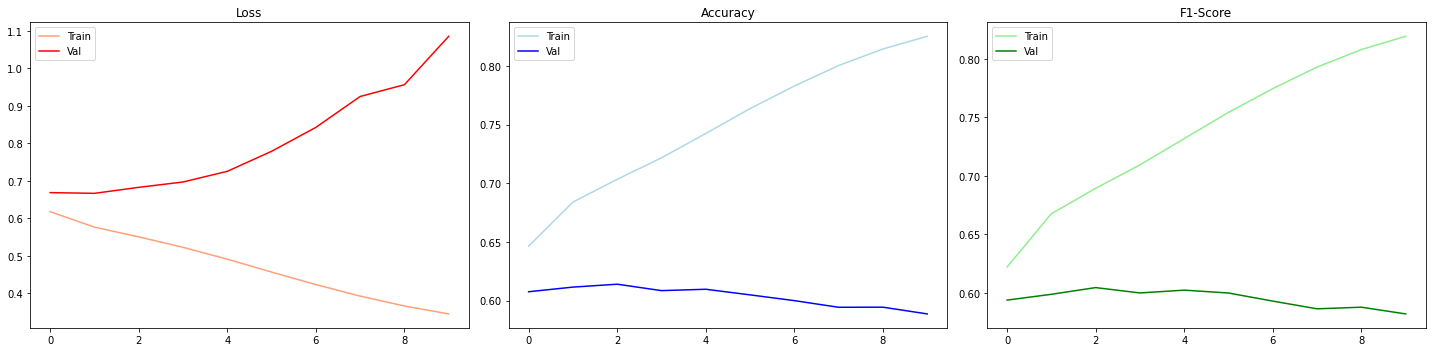

In [37]:
plot_metrics(model_metrics, cols,metrics,colors)

# Test set

In [38]:
best_model = Custom_model(embedding_matrix, model_param, DEVICE)
best_model.load_state_dict(torch.load('models/baseline.pt'))

criterion = nn.BCEWithLogitsLoss().to(DEVICE)    

best_metrics = eval_loop(best_model,test_dataloader,criterion,DEVICE)

<All keys matched successfully>

--------- VALIDATION START!


DEBUG:logger:eval epoch time: 2.5151371849997304


In [39]:
test_loss, test_acc, test_f1, test_pred, test_targ, test_ids = best_metrics

print(f'Test. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}% | Test. F1: {test_f1:.2f}')

Test. Loss: 0.652 | Test. Acc: 64.82% | Test. F1: 0.61


In [67]:
random_idx = random.randint(0, len(test_ids)-1)
print(f"Label predicted: {int(test_pred[random_idx])}")
print("Correct prediction :)") if int(test_pred[random_idx]) == int(test_targ[random_idx]) else print("Wrong prediction :(") 
print(f"Tweet: {(test['tweet'][test['tweet_id'] == int(test_ids[random_idx])]).values}")
test[test['tweet_id'] == int(test_ids[random_idx])]

Label predicted: 0
Wrong prediction :(
Tweet: [list(['yo', 'ttttt', 'can', 'we', 'push', 'our', 'tarkov', 'date', 'back', 'to', 'possibly', 'july', '22nd', 'things', 'came', 'up', 'hope', 'you', 'understand'])]


,tweet_id,account_id,tweet,neighbor,domain,label,profile.id,profile.id_str,profile.name,profile.screen_name,...,profile.profile_sidebar_border_color,profile.profile_sidebar_fill_color,profile.profile_text_color,profile.profile_use_background_image,profile.has_extended_profile,profile.default_profile,profile.default_profile_image,neighbor.following,neighbor.follower,idx_tweet
60356,60461,4699719036,"[yo, ttttt, can, we, push, our, tarkov, date, ...",NaN,[Business],1,4699719036,4699719036,Mizkif,REALMizkif,...,000000,000000,000000,False,True,False,False,"[2850939923, 621577260, 520680837, 215743018, ...","[1197117058716196864, 1247985590357934088, 124...","[259053, 112973, 46120, 22665, 278506, 150104,..."
